# Code for generating Figure 3

## "Parameter space geometry affects optimal learning trajectories"

This Python notebook contains code for generating the third figure from the paper "Gradient Descent as Loss Landscape Navigation: a Normative Framework for Deriving Learning Rules".

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# aesthetics
lw = 4

# ----------

# saving-related utility function
pic_folder = 'results/'
format_list = ['.png', '.svg', '.pdf']

def save_plot(name):
    for end in format_list:
        plt.savefig(pic_folder+name+end, bbox_inches='tight', transparent=True)
    return

<center>
<img src="fig_images/fig3-nongrad.png" width="1000"/></center>

**Caption.** (a) Optimal trajectory through $\theta_1$-$\theta_2$ space for an isotropic quadratic loss, assuming no nontrivial $\mathbf{G}$ and $\mathbf{f} \equiv \mathbf{0}$. The heatmap and contours show the value of the loss at each $(\theta_1, \theta_2)$ value. Black line: optimal trajectory, red dot: global minimum of loss. Note that, because the loss is isotropic, the optimal trajectory is too. (b) Same as (a), but given a strongly anisotropic constant metric $\mathbf{G}$. Note that the optimal trajectory is no longer the same along each direction, but converges much more quickly along the $\theta_1$ direction. (c) Same as (a), but given $\mathbf{f}$ that corresponds to purely rotational dynamics. Note two differences: it spirals about the origin, and no longer converges to the global minimum of the loss, but to a different point closer to the origin (orange dot). (d) Same as (a), but given $\mathbf{f}$ that corresponds to weight decay. There is no anisotropy, but the trajectory does not converge to the minimum of the loss.

In [5]:
# optimal learning trajectory, no nontrivial G or f
def get_curves_qloss_default(t, params):
    gamma, k, eta = params['gamma'], params['k'], params['eta']
    h = params['h']
    mu = params['mu']
    
    g = - h*mu
    theta_init = params['theta_init']
    theta_star = - g/h

    
    exp_arg =  np.sqrt( (gamma/2)**2 + eta*k*h ) - (gamma/2)   # shape: D
    theta = - (1 - np.exp(-exp_arg*t[:,None]))*(g[None,:]/h[None,:]) +  np.exp(-exp_arg*t[:,None])*theta_init  # shape: num_t, D
    return theta


# optimal learning trajectory given anisotropic parameter space metric
def get_curves_qloss_natgrad(t, params):
    gamma, k, eta = params['gamma'], params['k'], params['eta']
    h = params['h']
    G = params['G']
    mu = params['mu']
    
    g = - h*mu
    theta_init = params['theta_init']
    theta_star = mu
    

    exp_arg =  np.sqrt( (gamma/2)**2 + eta*k*h/G ) - (gamma/2)   # shape: D
    theta = - (1 - np.exp(-exp_arg*t[:,None]))*(g[None,:]/h[None,:]) +  np.exp(-exp_arg*t[:,None])*theta_init  # shape: num_t, D
    return theta


# optimal learning trajectory given rotational default dynamics
def get_curves_qloss_rotation(t, params):
    gamma, k, eta = params['gamma'], params['k'], params['eta']
    h = params['h']
    q = params['q']
    theta_init = params['theta_init']
    mu = params['mu']

    g = - h*mu
    theta_star =  mu
    h = h[0]

    ratio = (eta*k*h)/( (eta*k*h + q**2)**2 + (q*gamma)**2 )
    lamb = np.sqrt( (gamma/2)**2 + eta*k*h  ) - (gamma/2)
    mu_new = ratio*mu

    
    M_11 = 1 - np.exp(-lamb*t)*np.cos(q*t)
    M_12 = np.exp(-lamb*t)*np.sin(q*t)
    M_21 = - M_12
    M_22 = M_11

    A_11 = np.exp(-lamb*t)*np.cos(q*t)
    A_12 = - np.exp(-lamb*t)*np.sin(q*t)
    A_21 = - A_12
    A_22 = A_11
    
    v1 = (eta*k*h + q*q)*(theta_star[0]) - q*gamma*(theta_star[1])
    v2 = q*gamma*(theta_star[0]) + (eta*k*h + q*q)*(theta_star[1])

    
    theta_1 = ratio*( M_11*v1 + M_12*v2 ) + (A_11*theta_init[0] + A_12*theta_init[1])
    theta_2 = ratio*( M_21*v1 + M_22*v2 ) + (A_21*theta_init[0] + A_22*theta_init[1])
    return theta_1, theta_2, mu_new


# optimal learning trajectory given weight decay default dynamics
def get_curves_qloss_decay(t, params):
    gamma, k, eta = params['gamma'], params['k'], params['eta']
    h = params['h']
    j = params['j']
    theta_init = params['theta_init']
    
    g = - h*mu
    theta_star = mu
    B = (eta*k*h)/(eta*k*h + (j-gamma)*j)

    
    exp_arg =  np.sqrt( (gamma/2)**2 + eta*k*h + j*(j-gamma) ) - (gamma/2)   # shape: D
    theta = ((1 - np.exp(-exp_arg*t[:,None]))*B[None,:]*(theta_star[None,:])
              + np.exp(-exp_arg*t[:,None])*theta_init[None,:])  # shape: num_t, D
    mu_new = B*(theta_star)
    return theta, mu_new

In [7]:
t_min, t_max, num_t = 0, 100, 20000
t = np.linspace(t_min, t_max, num_t)

# parameter choices
mu = - np.array([0., 0.5])

gamma = 0
k = 1
eta = 1


h = np.array([ 4, 4])
G = 1/np.array([50, 1])
j = 10
q = 10

# initial parameter vector
theta_init = np.array([1.5, 1.5])


# collection of relevant parameters
params = {'gamma':gamma, 'k':k, 'eta':eta, 'h':h, 'G':G, 'j':j, 'q':q, 'mu':mu, 'theta_init':theta_init}


# get optimal learning trajectories under various conditions
theta_decay, mu_new_decay = get_curves_qloss_decay(t, params)
theta_natgrad = get_curves_qloss_natgrad(t, params)
theta_rot_1, theta_rot_2, mu_new_rot = get_curves_qloss_rotation(t, params)
theta_default = get_curves_qloss_default(t, params)

# -------------------------

# make x-y grid and compute loss on grid

x_min, x_max, num_x = -2, 2, 100  
y_min, y_max, num_y = -2, 2, 100

x = np.linspace(x_min, x_max, num_x)
y = np.linspace(y_min, y_max, num_y)
x_, y_ = np.meshgrid(x, y, indexing='ij')

L = 0.5*h[0]*(x_ - mu[0])**2 + 0.5*h[1]*(y_ - mu[1])**2

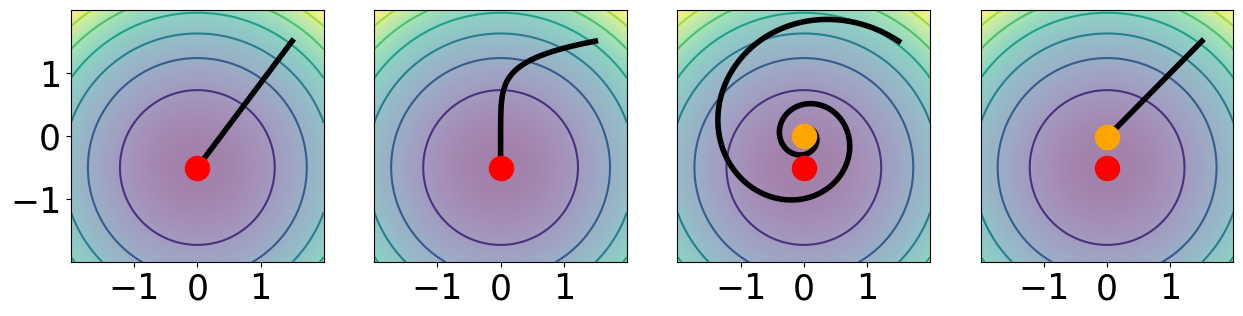

In [9]:
# plot panels of final figure

fig, ax = plt.subplots(ncols=4, figsize=(15,4), sharex=True, sharey=False)

# plot loss as heatmap
for i in range(0, 4):
    ax[i].contour(x_, y_, L)
    ax[i].imshow(L.T, extent = [x_min, x_max, y_min, y_max], origin='lower', alpha=0.5)

# plot optimal learning trajectories
ax[0].plot(theta_default[:,0], theta_default[:,1], 'black', linewidth=lw)
ax[1].plot(theta_natgrad[:,0], theta_natgrad[:,1], 'black', linewidth=lw)
ax[2].plot(theta_rot_1, theta_rot_2, 'black', linewidth=lw)
ax[3].plot(theta_decay[:,0], theta_decay[:,1], 'black', linewidth=lw)


# plot end of trajectories and minimum of loss
for i in range(0, 4):
    ax[i].scatter(mu[0], mu[1], s=300, color='red', zorder=3)
ax[2].scatter(mu_new_rot[0], mu_new_rot[1], s=300, color='orange', zorder=3)
ax[3].scatter(mu_new_decay[0], mu_new_decay[1], s=300, color='orange', zorder=3)


# labels
for i in range(0, 4):
    ax[i].tick_params(axis='both', which='major', labelsize=25)
ax[0].set_xticks([-1, 0, 1])
ax[0].set_yticks([-1, 0, 1])
ax[1].set_yticks([]); ax[2].set_yticks([]); ax[3].set_yticks([])


# save, show
save_plot('nongrad_big')
plt.show()